In [12]:
# Quelques imports nécéssaires au bon déroulement du projet

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

### Partie I : Orbite d'un corps autour du soleil

Ici, on va tenter de formaliser l'orbite d'un corps autour d'une planète en passant par les expressions des différentes anomalies.

D'abord, l'anomalie moyenne M peut être calculée facilement en fonction du temps et du moyen mouvement d'une planète. Ces moyens mouvements sont facilement trouvables sur le net.

On va effectuer nos calculs pour la planète Terre afin d'éprouver leur efficacité.

In [13]:
# Fonction calculant l'anomalie moyenne en fonction du temps, du moyen mouvement d'un corps, et de l'origine des temps, passage de la planète au périapside
def M(t,m,t0):
    return m*(t-t0)

On peut utiliser cette anomalie moyenne pour déterminer l'anomalie excentrique à un instant t.
Le détail du calcul est trouvable sur la page wikipedia de l'anomalie excentrique.

In [14]:
# Fonction calculant l'anomalie excentrique en fonction de l'anomalie moyenne et de l'excentricité
def E(M,e):
    E = M
    for i in range(0,5):
        E = M + e * np.sin(E)
    return E

De cette anomalie excentrique peut être déduite l'anomalie vrai à l'instant t.

In [15]:
def V(E,e):
    return np.arccos((np.cos(E)-e)/(1-(e*np.cos(E))))

Finalement, on utilise cette anomalie vraie pour déterminer la distance du corps à son astre, en fonction du demi grand-axe a.

In [16]:
def R(anom, a, e):
    return ((a*(1-e**2))/(1+e*np.cos(anom)))

Eprouvons maintenant ces méthodes sur l'orbite terrestre. Cette orbite dure 365 jours environ. Cela donne 31536000 secondes.

In [101]:
year=31536000 #s
nbdays=365 #j
time=np.linspace(0,year,nbdays)
ex_terre=0.01671022
a=149.6*10**9 #m
mm=1.9907e-7 #rad/s
t0=0 #s

#Calcul pour la terre
M_terre=M(time,mm,t0)
E_terre=E(Ml,ex_terre)
V_terre=V(El,ex_terre)
R_terre=R(Vl,a,ex_terre)

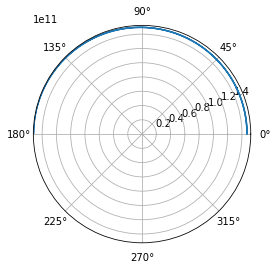

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.plot(V_terre,R_terre)
plt.show()

In [103]:
#Ajout des données pour les orbites des différentes planètes 
data=pd.read_csv('dataplanets.csv',delimiter=',' )


#Organisation des données par listes
nom = data.PLANETE.tolist()
demi_gd_axe=data.DEMIGRANDAXE.tolist()
moy_mouv=data.MOYENMOUVEMENT.tolist()
excentricite=data.EXCENTRICITE.tolist()

#Création des listes pour les valeurs calculées
M_list=[]
E_list=[]
V_list=[]
R_list=[]

#Remplissage des listes pour le calcul des orbites
for i in range(len(nom)):
    M_list.append(M(time,moy_mouv[i],t0))
    E_list.append(E(M_list[i],excentricite[i]))
    V_list.append(V(E_list[i],excentricite[i]))
    R_list.append(R(V_list[i],demi_gd_axe[i],excentricite[i]))
    
print(nom)

['MERCURE', 'VENUS', 'TERRE', 'MARS', 'JUPITER', 'SATURNE', 'URANUS', 'NEPTUNE']


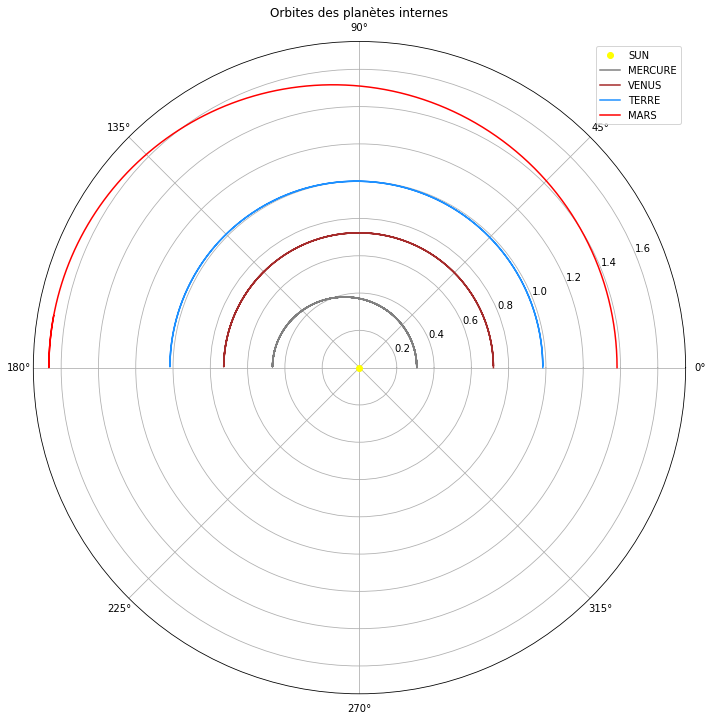

In [100]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='polar')

ax.plot(0,0,'ro',c='yellow',label='SUN')

ax.plot(V_list[0],R_list[0], c='grey', label='MERCURE')
ax.plot(V_list[1],R_list[1], c='brown', label='VENUS')
ax.plot(V_list[2],R_list[2], c='dodgerblue', label='TERRE')
ax.plot(V_list[3],R_list[3], c='red', label='MARS')




plt.title("Orbites des planètes internes")


legend = plt.legend(loc = 'best')


plt.show()

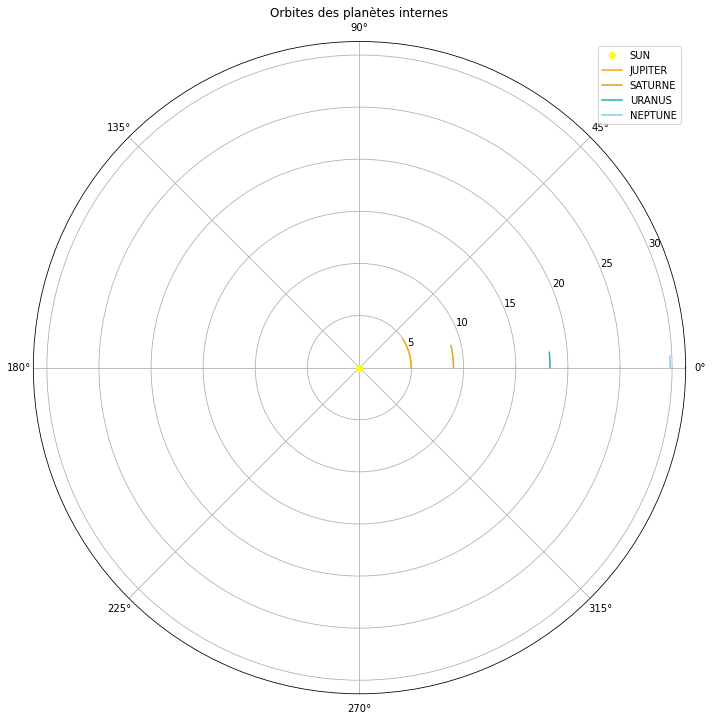

In [109]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='polar')

#Le soleil
ax.plot(0,0,'ro',c='yellow',label='SUN')

#Les planètes extérieures
ax.plot(V_list[4],R_list[4], c='orange', label='JUPITER')
ax.plot(V_list[5],R_list[5], c='goldenrod', label='SATURNE')
ax.plot(V_list[6],R_list[6], c='lightseagreen', label='URANUS')
ax.plot(V_list[7],R_list[7], c='skyblue', label='NEPTUNE')

plt.title("Orbites des planètes internes")

legend = plt.legend(loc = 'best')

plt.show()

#Je ne comprends pas pourquoi le plot ne fait pas 180°